In [1]:
import math
import numpy as np
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import set_matplotlib_formats, display, Math
import requests
import datetime

# My favorite figure's settings
set_matplotlib_formats('svg')
mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['font.size'] = '16.'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'].remove('Times New Roman')
# plt.rcParams['font.serif'].insert(0, 'Times New Roman')
plt.rcParams['font.serif'].insert(0, 'Iowan Old Style BT')
plt.rcParams['font.sans-serif'].insert(0, 'SF Pro Text')

In [2]:
r = requests.get(r'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv')
date = []
value = []
for line in r.text.split('\n')[1:]:
    tmp = line.strip().split(',')
    if len(tmp) == 3:
        d = list(map(int, tmp[0].split('/')))
        date.append(datetime.date(*d))
        value.append(int(tmp[2]))
raw_date = np.array(date)
raw_value = np.array(value)
date = np.unique(raw_date)

In [3]:
indices = [np.nonzero(raw_date == d)[0][0] for d in date]
value = raw_value[indices]

## Least Square Method

$$\begin{align}
y &= b\exp(ax) \\
\log(y) &= ax + \log(b)
\end{align}$$
Consider the least square method,
$$\begin{align}
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
&=
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
\end{align}$$

$$
\begin{align}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
&=
\left(\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}\right)^{-1}
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
\end{align}$$

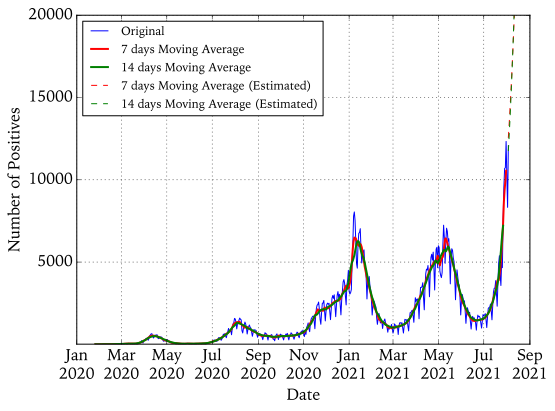

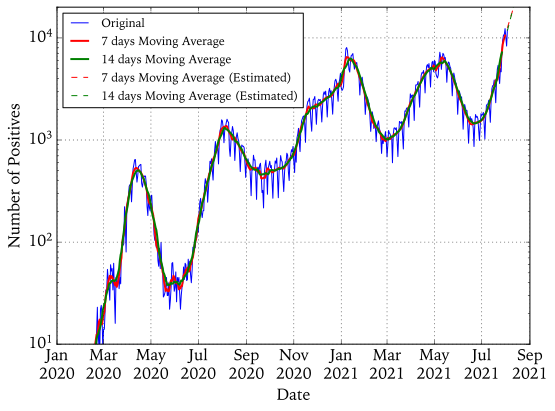

In [4]:
def date2num(x):
    f = np.frompyfunc(lambda x: x.toordinal(), 1, 1)
    return f(x)


def num2date(x):
    f = np.frompyfunc(lambda x: datetime.date.fromordinal(x), 1, 1)
    return f(x)


def lsm(x, y):
    A = np.vstack([x - x.min(), np.ones(x.size)]).astype(np.float64).T
    y = np.log(y)
    b = np.linalg.pinv(A) @ y
    return b[0], np.exp(b[1]), x.min()


def exp_delay(x, a, b, c):
    return b * np.exp(a * (x - c))



value_smoothed = np.convolve(np.ones(7)/7, value, 'same')[:-3]
value_smoothed2 = np.convolve(np.ones(14)/14, value, 'same')[:-7]
date_smoothed = date[:value_smoothed.size]
date_smoothed2 = date[:value_smoothed2.size]

a, b, c = lsm(date2num(date_smoothed[-3:]), value_smoothed[-3:])
a2, b2, c2 = lsm(date2num(date_smoothed2[-3:]), value_smoothed2[-3:])

date_plot = np.arange(30) + date[-1].toordinal()

now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
locator = mdates.MonthLocator(bymonth=range(1, 13, 2))
formatter = mdates.DateFormatter('%b\n%Y')

plt.figure(tight_layout=True)
ax = plt.gca()
ax.plot(date, value, label='Original')
ax.plot(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.plot(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.plot(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.plot(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_plot_{}.png'.format(now), dpi=600)
plt.savefig('figs/positives_plot_{}.svg'.format(now))
plt.show()

plt.figure(tight_layout=True)
ax = plt.gca()
ax.semilogy(date, value, label='Original')
ax.semilogy(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.semilogy(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_semilogy_{}.png'.format(now), dpi=600)
plt.savefig('figs/positives_semilogy_{}.svg'.format(now))
plt.show()

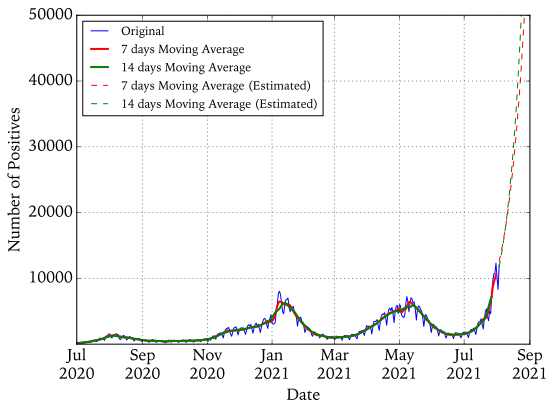

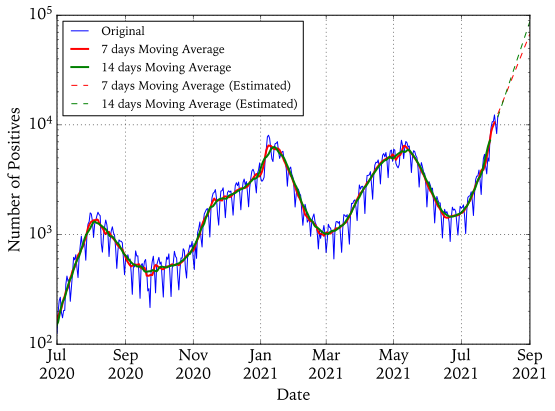

In [5]:
plt.figure(tight_layout=True)
ax = plt.gca()
ax.plot(date, value, label='Original')
ax.plot(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.plot(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.plot(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.plot(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 7, 1), None)
ax.set_ylim(10, 50000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_plot_detail_{}.png'.format(now), dpi=600)
plt.savefig('figs/positives_plot_detail_{}.svg'.format(now))
plt.show()

plt.figure(tight_layout=True)
ax = plt.gca()
ax.semilogy(date, value, label='Original')
ax.semilogy(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.semilogy(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 7, 1), None)
ax.set_ylim(100, 1e5)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_semilogy_detail_{}.png'.format(now), dpi=600)
plt.savefig('figs/positives_semilogy_detail_{}.svg'.format(now))
plt.show()